In [1]:
import os
os.chdir('../')

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd

adata_list=[]
adata_list.append(sc.read_h5ad("dataset/SRT_data/151507_adata.h5ad"))
adata_list.append(sc.read_h5ad("dataset/SRT_data/151669_adata.h5ad"))
adata_list.append(sc.read_h5ad("dataset/SRT_data/151673_adata.h5ad"))

sc_adata = sc.read_h5ad("dataset/SC_data/scref_adata.h5ad")

/public/home/dongqishi/.local/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/public/home/dongqishi/.local/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/public/home/dongqishi/.local/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/public/home/dongqishi/.local/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/public/home/dongqishi/.local/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `annda

In [3]:
import os
from R_initialization import FUSION_Init

R_HOME='/public/home/dongqishi/miniconda3/envs/gpu/lib/R'
R_USER='/public/home/dongqishi/miniconda3/envs/gpu/site-packages/rpy2'

domain_size=7

FUSION_Init([adata_list], sc_adata,domain_size, R_HOME, R_USER)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In .recacheSubclasses(def@className, def, env) :
R[write to console]: 
 
R[write to console]:  undefined subclass "ndiMatrix" of class "replValueSp"; definition not updated



Section0 initialization complete


In [4]:
from main_ref import FUSION_preprocess

seed=123

log_fc_cut=1.5

FUSION_preprocess([adata_list], log_fc_cut, seed)

Total slice loaded: 1
RangeIndex(start=0, stop=11524, step=1)
Batch merging complete
parition complete
        start_idx  end_idx
origin                    
batch1          0     4225
batch2       4225     7885
batch3       7885    11524
preprocess complete


In [10]:
import torch 
device = torch.device('cuda:1' if torch.cuda.device_count() > 0 else 'cpu')
print(f'Training on: {device}')

from main_ref import FUSION_main

embed_dim=50

alpha,beta=1,10

out, embeddings = FUSION_main([adata_list], embed_dim, domain_size, [[alpha,beta]], False, device, seed)

Training on: cuda:1


100%|██████████| 50/50 [00:02<00:00, 20.01it/s]


Detected Domain Size across Slices:[6, 4, 6]


In [12]:
from r_batch import FUSION_correction

refined_embed= FUSION_correction([adata_list], embeddings, seed)

ARI of joint section analysis:0.6100711069340277


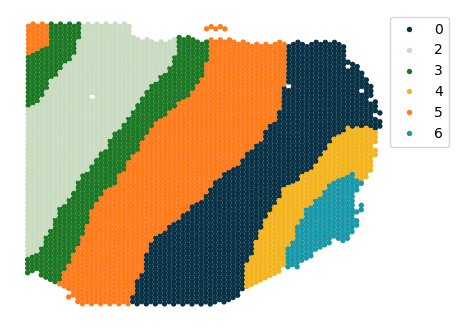

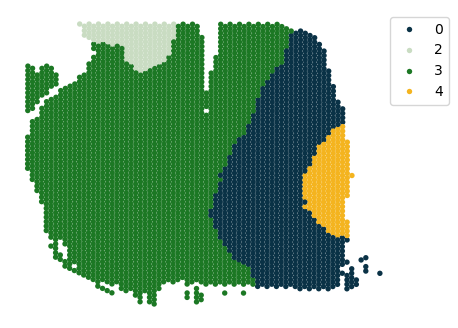

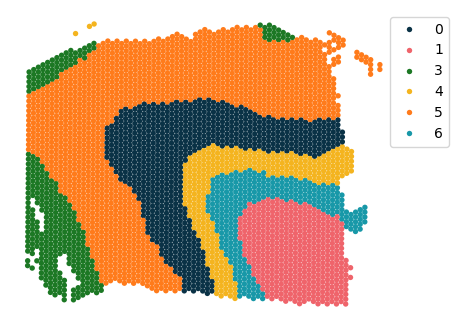

In [13]:
from utils import domain_plot
import pickle
from sklearn.metrics.cluster import adjusted_rand_score

ARI_tmp=[]
truth_list=[]

for i in range(3):
    
    with open('dataset/SRT_data/truth_list_DLPFC{}.pkl'.format(4*(i+1)), 'rb') as f:
        truth = pickle.load(f)
    
    truth_list.append(truth[0])
    
    combined_array = out [0][out [0]['slide']==i].loc[:,['domain','x','y']]

    combined_array.columns=['est_do', 'imagerow', 'imagecol']

    combined_array = np.hstack((combined_array['est_do'].values.reshape(-1,1), truth[0].reshape(-1,1)))

    ARI_tmp.append(combined_array)

ARI=[]
for res in ARI_tmp:
    ARI.append(adjusted_rand_score(res[:,1],res[:,0]))

print('ARI of joint section analysis:{}'.format(np.median(ARI[0:3])))

color_dict={1:(239,100,107), 0:(10,50,70),5:(255,123,27),4:(244,180,31),3:(28,120,36),6:(24,152,168),2:(201,220,194)}

cell_size=15

for i in range(3):
    c_slide=out[0][out[0]['slide']==i]
    domain_plot(c_slide['domain'].values,c_slide[['x','y']].values,color_dict, cell_size, (5,4))

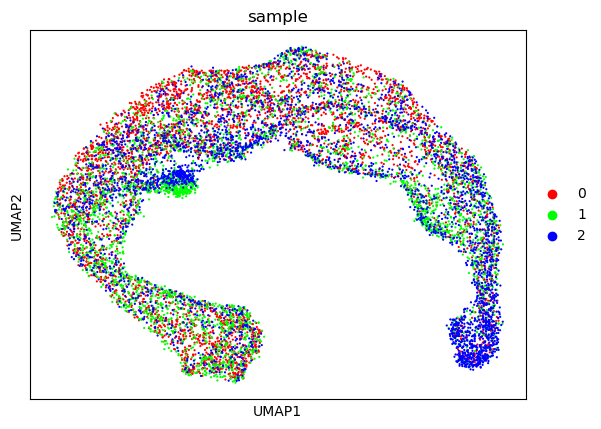

Mean iLISI: 2.43


In [14]:
from utils import compute_lisi
def list2df(list_of_lists1, list_of_lists2):

    # Create a list to store the data for the DataFrame
    data = []

    # Loop through the list of lists
    for idx, sublist in enumerate(list_of_lists1):
        for idx_2,label in enumerate(sublist):
            data.append({'domain': label, 'truth':list_of_lists2[idx][idx_2],'sample': idx})
    

    # Create a DataFrame from the data
    df = pd.DataFrame(data)
    
    df['domain'] = df['domain'].astype('category')
    df['sample'] = df['sample'].astype('category')
    df['truth'] = df['truth'].astype('category')
    
    return df


custom_colors =  [
    (255, 0, 0),       # Red
    (0, 255, 0),       # Green
    (0, 0, 255),       # Blue
]

normalized_colors = [(r/255, g/255, b/255) for r, g, b in custom_colors]

adata_batch= sc.AnnData(np.vstack(refined_embed))
adata_batch.obs=list2df([out[0]['domain'][out[0]['slide']==i].values for i in range(3)], [truth_list[i] for i in range(3)])

sc.pp.neighbors(adata_batch)
sc.tl.umap(adata_batch, min_dist=0.5,init_pos='spectral',random_state=123)             # Compute UMAP
sc.pl.umap(adata_batch, color='sample', palette=normalized_colors, size=10.0)

embedding = adata_batch.obsm['X_umap']
dataset_labels = adata_batch.obs['sample'].values
ilisi_scores = compute_lisi(embedding, dataset_labels, k=30)
print(f"Mean iLISI: {np.mean(ilisi_scores):.2f}")# Compute UMAP